In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# 그래프 기본 테마 설정
# https://coldbrown.co.kr/2023/07/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%8B%A4%EC%A0%84%ED%8E%B8-08-seaborn-sns-set%EC%9D%84-%ED%86%B5%ED%95%B4-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0/
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] a= 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False


# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

In [2]:
df = pd.read_csv('data/merged_data_brand_dropna.csv')

In [3]:
# datetime 컬럼 변환
df['event_time_moscow'] = pd.to_datetime(df['event_time_moscow'])

## cart 행동 기반 코호트 분석

- **장바구니 행동 기반**
    - 조건: **장바구니(cart)** 에 3회 이상 담은 사용자
    - 코호트 기준: `user_id`가 장바구니 이벤트를 3회 이상 발생시킨 첫 시점
    - 분석: 이후 n일 내 구매율 변화 추적

In [4]:
import pandas as pd

# 1. event_time 처리
df['event_time'] = pd.to_datetime(df['event_time_moscow'], errors='coerce')
df = df.sort_values(by=['user_id', 'event_time'])  # 시간 순 정렬

In [5]:
# 2. cart 이벤트만 필터링
cart_df = df[df['event_type'] == 'cart'].copy()

# 3. 사용자별 cart 이벤트 누적 카운트
cart_df['cart_cumcount'] = cart_df.groupby('user_id').cumcount() + 1

# 4. 3번째 cart 이벤트만 추출
cart_3rd_df = cart_df[cart_df['cart_cumcount'] == 3].copy()

# 5. user_id별로 cart 3회차 시점 확인
user_cart3_time = cart_3rd_df[['user_id', 'event_time']].rename(columns={'event_time': 'cohort_time'})

In [6]:
# 6. 전체 df에 cohort_time 병합
df = df.merge(user_cart3_time, on='user_id', how='inner')  # 3회 이상 cart 한 유저만

# 7. 기준일 이후 이벤트만 필터링
df = df[df['event_time'] >= df['cohort_time']].copy()

# 8. 기준 시점 대비 N일 경과 계산
df['days_since_cart3'] = (df['event_time'] - df['cohort_time']).dt.days

In [7]:
# 9. 중복 제거: 유저가 특정 일에 구매했는지 여부만 체크
purchase_log = df[df['event_type'] == 'purchase'][['user_id', 'days_since_cart3']].drop_duplicates()

# 10. 전체 유저 수 (코호트 기준 유저)
total_users = user_cart3_time['user_id'].nunique()

# 11. 일자별 구매 유저 수
daily_purchases = (
    purchase_log.groupby('days_since_cart3')['user_id'].nunique()
    .reindex(range(0, 15), fill_value=0)  # 최대 15일까지 보고 싶다면
)

# 12. 구매율 계산
purchase_rate = daily_purchases / total_users * 100
purchase_rate.name = 'purchase_rate'

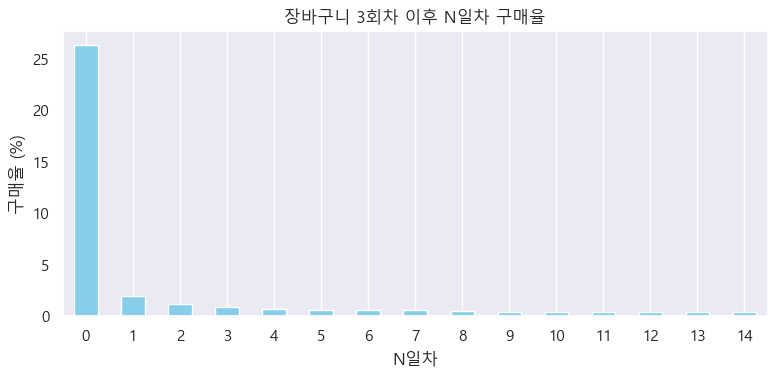

In [8]:
import matplotlib.pyplot as plt

# 13. 시각화
plt.figure(figsize=(8, 4))
purchase_rate.plot(kind='bar', color='skyblue')
plt.title('장바구니 3회차 이후 N일차 구매율')
plt.xlabel('N일차')
plt.ylabel('구매율 (%)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 14. CSV 저장 (선택)
purchase_rate.reset_index().rename(columns={'index': 'days_since_cart3'}).to_csv('cohort_cart3_purchase_rate.csv', index=False)

- 유의미하게 높거나, 특출나지 않음

- 장바구니 3회까지 걸리는 시간을 기준으로 그룹 분할
- 1일 이내, 3일 이내, 7일 이내, 7일 초과

In [9]:
import pandas as pd

# cart 이벤트만 필터링
cart_df = df[df['event_type'] == 'cart'].copy()
cart_df['event_time'] = pd.to_datetime(cart_df['event_time_moscow'], errors='coerce')
cart_df = cart_df.sort_values(by=['user_id', 'event_time'])

# 각 user_id 내에서 cart 이벤트 순서 부여
cart_df['cart_order'] = cart_df.groupby('user_id').cumcount() + 1

# 1회차와 3회차 추출
cart1 = cart_df[cart_df['cart_order'] == 1][['user_id', 'event_time']].rename(columns={'event_time': 'cart1_time'})
cart3 = cart_df[cart_df['cart_order'] == 3][['user_id', 'event_time']].rename(columns={'event_time': 'cart3_time'})

# 병합 후 시간 차 계산
cart_duration = pd.merge(cart1, cart3, on='user_id')
cart_duration['days_to_3rd_cart'] = (cart_duration['cart3_time'] - cart_duration['cart1_time']).dt.days

In [10]:
# 코호트 그룹 분류 (예시: 빠름/중간/느림)
def categorize_days(days):
    if days <= 1:
        return '1일 이내'
    elif days <= 3:
        return '3일 이내'
    elif days <= 7:
        return '7일 이내'
    else:
        return '7일 초과'

cart_duration['cohort_group'] = cart_duration['days_to_3rd_cart'].apply(categorize_days)

In [13]:
cart_duration['cohort_group'].value_counts()

cohort_group
1일 이내    120043
7일 초과      9905
7일 이내      2786
3일 이내      2250
Name: count, dtype: int64

In [14]:
# cart3_time 기준 이후 행동만 분석
df['event_time'] = pd.to_datetime(df['event_time_moscow'], errors='coerce')
df = df.merge(cart_duration[['user_id', 'cart3_time', 'cohort_group']], on='user_id', how='inner')
df = df[df['event_time'] >= df['cart3_time']].copy()
df['days_since_cart3'] = (df['event_time'] - df['cart3_time']).dt.days

In [15]:
# 구매 로그만 추출
purchase_log = df[df['event_type'] == 'purchase'][['user_id', 'days_since_cart3', 'cohort_group']].drop_duplicates()

# 전체 유저 수 (코호트별)
cohort_user_counts = cart_duration.groupby('cohort_group')['user_id'].nunique()

# 일자별 구매자 수
daily_purchase = (
    purchase_log.groupby(['cohort_group', 'days_since_cart3'])['user_id'].nunique()
    .unstack(fill_value=0)
)

# 비율로 전환
cohort_purchase_rate = daily_purchase.divide(cohort_user_counts, axis=0) * 100

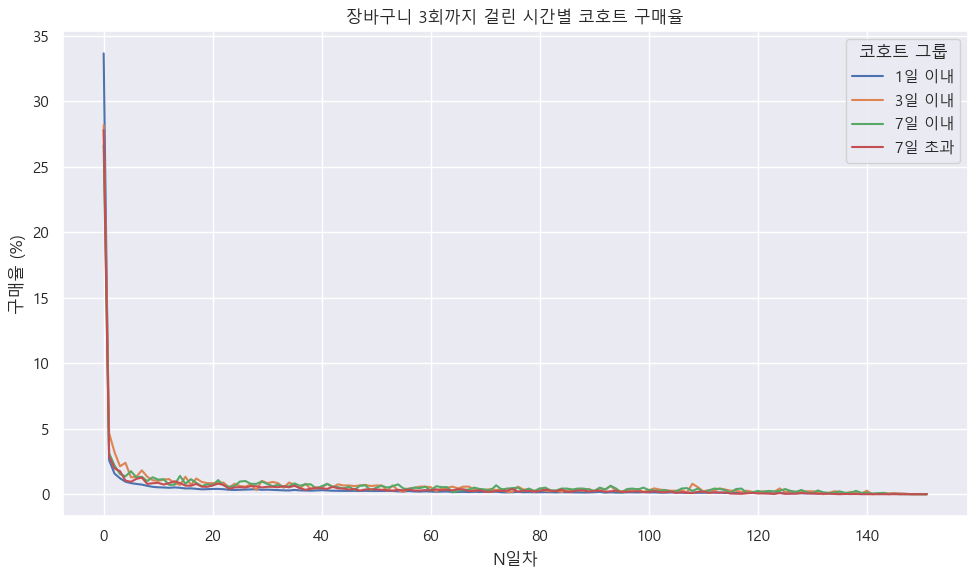

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for cohort in cohort_purchase_rate.index:
    plt.plot(cohort_purchase_rate.columns, cohort_purchase_rate.loc[cohort], label=cohort)

plt.title('장바구니 3회까지 걸린 시간별 코호트 구매율')
plt.xlabel('N일차')
plt.ylabel('구매율 (%)')
plt.legend(title='코호트 그룹')
plt.grid(True)
plt.tight_layout()
plt.show()

- 장바구니 3회를 며칠에 걸쳐 달성했는지는 큰 유의미성을 보이지는 않는다.
- 3일 이내, 7일 이내 그룹이 비교적 높고, 1일 이내가 비교적 낮은 듯

### 가설 검정

- 귀무가설(H₀): cart에 3회 이상 담은 사용자와 그렇지 않은 사용자 간 구매율 차이가 없다.
- 대립가설(H₁): cart에 3회 이상 담은 사용자가 이후 구매율이 더 높다.

In [21]:
import pandas as pd
from scipy.stats import chi2_contingency

# 1. event_time 형 변환 및 정렬
df['event_time'] = pd.to_datetime(df['event_time_moscow'])
df = df.sort_values(['user_id', 'event_time'])

# 2. cart 이벤트 필터링 후 순서 부여
cart_df = df[df['event_type'] == 'cart'].copy()
cart_df['cart_order'] = cart_df.groupby('user_id').cumcount() + 1

# 3. 사용자별 3번째 cart 시점 추출
third_cart_time = cart_df[cart_df['cart_order'] == 3][['user_id', 'event_time']]
third_cart_time.columns = ['user_id', 'cart3_time']  # 병합을 위한 컬럼명 변경

# 4. 원본 df에 cart3_time 병합
df = df.merge(third_cart_time, on='user_id', how='left')

# 5. cart3 이후 이벤트 여부 플래그 생성
df['after_cart3'] = df['event_time'] > df['cart3_time']

# 6. cart 3회 이상 사용자 리스트
users_with_cart3 = third_cart_time['user_id'].unique()

# 7. cart 3회 미만 사용자 리스트
users_without_cart3 = df[~df['user_id'].isin(users_with_cart3)]['user_id'].unique()

# 8. cart3 이후에 구매한 사용자 추출
purchase_after_cart3 = df[
    (df['event_type'] == 'purchase') &
    (df['after_cart3'] == True)
]['user_id'].unique()

# 9. 그룹별 구매 여부 계산
a_purchase = sum(pd.Series(users_with_cart3).isin(purchase_after_cart3))
a_non = len(users_with_cart3) - a_purchase

b_purchase = sum(pd.Series(users_without_cart3).isin(purchase_after_cart3))
b_non = len(users_without_cart3) - b_purchase

# 10. 교차표 생성 및 카이제곱 검정
contingency = [[a_purchase, a_non], [b_purchase, b_non]]
chi2, p, _, _ = chi2_contingency(contingency)

# 11. 구매율 계산
a_rate = a_purchase / (a_purchase + a_non) if (a_purchase + a_non) > 0 else 0
b_rate = b_purchase / (b_purchase + b_non) if (b_purchase + b_non) > 0 else 0

# 12. 결과 출력
print("✅ 교차표:", contingency)
print(f"✅ p-value: {p:.5f}")
print(f"✅ cart 3회 이상 사용자 구매율: {a_rate:.2%}")
print(f"✅ cart 3회 미만 사용자 구매율: {b_rate:.2%}")

✅ 교차표: [[53959, 51989], [0, 29036]]
✅ p-value: 0.00000
✅ cart 3회 이상 사용자 구매율: 50.93%
✅ cart 3회 미만 사용자 구매율: 0.00%


- cart에 3회 이상 담은 이들의 차후 구매율이 높다.